In [1]:
# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set()

# statsmodels
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

# sktime：グラフ描画
from sktime.utils.plotting import plot_series

# sktime：予測
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster

# sktime：予測の評価指標
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    MeanAbsoluteError,
    mean_absolute_percentage_error,
    mean_absolute_error,
)

# sktime：予測の評価
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
)
from sktime.forecasting.model_evaluation import evaluate

# sktime：データの変換
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

# sktime：パイプライン
from sktime.forecasting.compose import TransformedTargetForecaster, MultiplexForecaster
from sktime.pipeline import make_pipeline
from sktime.transformations.compose import OptionalPassthrough

# 機械学習法
import lightgbm as lgb

# 再帰的に回帰分析を実行するための関数の読み込み
from sktime.forecasting.compose import make_reduction

# 周期性やトレンドの関する特徴量を作成
from statsmodels.tsa.deterministic import DeterministicProcess

# グラフの日本語表記
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"

In [29]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

# Warningを出力させないようにする
import warnings
import lightgbm

# ======================================================
# 1. LightGBM のメモリ警告（np.ndarray subset）
# ======================================================
warnings.filterwarnings(
    "ignore",
    message="Usage of np.ndarray subset",
    category=UserWarning,
    module="lightgbm",
)

# LightGBM が内部で _log_warning を使って出す全ての警告も無効化
lightgbm.basic._log_warning = lambda x: None


# ======================================================
# 2. pandas dtype 警告（sktime 内部）
# ======================================================
warnings.filterwarnings(
    "ignore",
    message="Setting an item of incompatible dtype is deprecated",
    category=FutureWarning,
    module="sktime.transformations.series.summarize",
)

# sktime 全般の FutureWarning を無視
warnings.filterwarnings("ignore", category=FutureWarning, module="sktime")


# ======================================================
# 3. その他の安全策（全体の警告出力を非表示）
# ======================================================
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

print("✅ LightGBM / sktime の警告を完全に抑止しました。")

✅ LightGBM / sktime の警告を完全に抑止しました。


In [3]:
# オオヤマネコデータの読み込み
lynx = sm.datasets.get_rdataset("lynx").data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(start="1821-01", periods=len(lynx), freq="Y")
lynx.index = date_index

# 不要な時間ラベルの削除
lynx = lynx.drop(lynx.columns[0], axis=1)

# 結果の確認
print(lynx.head(10))

      value
1821    269
1822    321
1823    585
1824    871
1825   1475
1826   2821
1827   3928
1828   5943
1829   4950
1830   2577


In [4]:
# 参考：データの年数
len(lynx)

114

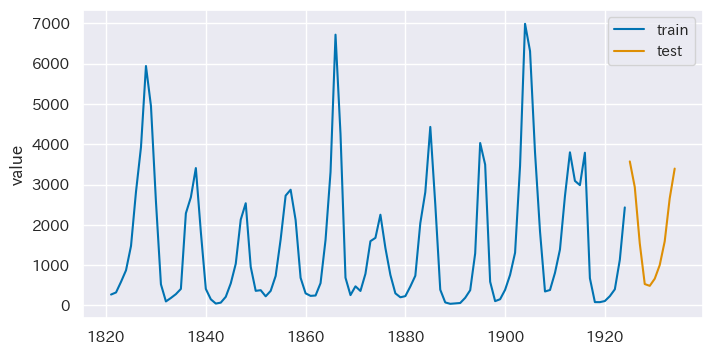

In [5]:
# 訓練データとテストデータに分割する
train_lynx, test_lynx = temporal_train_test_split(lynx, test_size=10)

# 折れ線グラフを描く
fig, ax = plot_series(
    train_lynx, test_lynx, labels=["train", "test"], markers=np.tile("", 2)
)

# グラフサイズの指定
fig.set_size_inches(8, 4)

In [6]:
# 予測期間
fh_lynx = np.arange(1, len(test_lynx) + 1)
fh_lynx

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [7]:
# ============================================================
# ラグデータ（過去データの遅れ変数）を作成する処理
# ============================================================

# ------------------------------------------------------------
# ラグの設定
# ------------------------------------------------------------
# 「lag = 10」は、現在時点 t の値を予測する際に
# 「過去10時点分のデータ（t-1 ~ t-10）」を説明変数として使うという意味。
# これは自己回帰モデル（ARモデル）やニューラルネットなどで
# 時系列の依存構造を捉えるための一般的な特徴量設計である。
lag = 10

# ------------------------------------------------------------
# lagmat関数によるラグ行列の生成
# ------------------------------------------------------------
# statsmodels.tsa.api.lagmat() は、与えられた系列から「ラグ行列（遅れ変数行列）」を生成する。
# 各行は1時点分の観測データを表し、列には t-1, t-2, ..., t-10 の値が順に並ぶ。
#
# 引数の意味：
# - train_lynx : 対象の時系列データ（例：カナダのオオヤマネコの捕獲数）
# - maxlag=lag : 作成する最大ラグの数
# - original='ex' : 元の系列を除外し、ラグのみを含む（＝説明変数行列）
# - trim='both' : ラグが計算できない先頭および末尾の行を削除
# - use_pandas=True : pandas.DataFrame形式で出力
#
# この処理により、自己回帰モデル（ARモデル）を OLS で推定するための
# デザイン行列（説明変数行列）が得られる。
lynx_lag = tsa.lagmat(
    train_lynx,
    maxlag=lag,  # ラグ数10
    original="ex",  # 元系列は除外（説明変数としてラグのみを使用）
    trim="both",  # 欠損の出る前後を削除
    use_pandas=True,  # pandasで返す
)

# ------------------------------------------------------------
# 結果の確認
# ------------------------------------------------------------
# 生成されたラグ行列の上位3行を出力。
# 各列は t-1, t-2, ..., t-10 の値を表している。
print(lynx_lag.head(3))

      value.L.1  value.L.2  value.L.3  value.L.4  value.L.5  value.L.6  \
1831     2577.0     4950.0     5943.0     3928.0     2821.0     1475.0   
1832      523.0     2577.0     4950.0     5943.0     3928.0     2821.0   
1833       98.0      523.0     2577.0     4950.0     5943.0     3928.0   

      value.L.7  value.L.8  value.L.9  value.L.10  
1831      871.0      585.0      321.0       269.0  
1832     1475.0      871.0      585.0       321.0  
1833     2821.0     1475.0      871.0       585.0  


In [8]:
# 結果の確認
print(train_lynx["1831":"1841"])

      value
1831    523
1832     98
1833    184
1834    279
1835    409
1836   2285
1837   2685
1838   3409
1839   1824
1840    409
1841    151


In [9]:
# LightGBMのハイパーパラメータを設定
params = {
    "objective": "regression",  # 回帰を目的とする
    "seed": 1,  # 乱数の種
    "num_leaves": 20,  # 葉の数の最大値
    "learning_rate": 0.05,  # 学習率
    "n_estimators": 100,  # ブースティングの回数
    "min_data_in_leaf": 1,  # 1つの葉における最小データ数
    "verbose": -1,  # ワーニングなどの非表示
}

In [10]:
# モデル化
gbm = lgb.LGBMRegressor(**params)

# モデルの当てはめ
gbm.fit(lynx_lag, train_lynx.loc["1831":])

LGBMRegressor(learning_rate=0.05, min_data_in_leaf=1, num_leaves=20,
              objective='regression', seed=1, verbose=-1)

In [11]:
# テストデータの最初の値
print(test_lynx.head(1))

      value
1925   3574


In [12]:
# ラグデータの作成
lynx_lag_all = tsa.lagmat(lynx, maxlag=lag, original="ex", trim="both", use_pandas=True)

# 結果の確認
print(lynx_lag_all.loc["1925":"1925"])

      value.L.1  value.L.2  value.L.3  value.L.4  value.L.5  value.L.6  \
1925     2432.0     1132.0      399.0      229.0      108.0       80.0   

      value.L.7  value.L.8  value.L.9  value.L.10  
1925       81.0      674.0     3790.0      2985.0  


In [13]:
# testデータの最初の1年目を予測
gbm.predict(lynx_lag_all.loc["1925":"1925"])

array([2281.66646241])

In [14]:
# 2時点先予測に使う説明変数
x_target = lynx_lag_all.loc["1925":"1925"].copy()
x_target.iloc[:, 1:] = x_target.iloc[:, 0:9]
x_target.iloc[:, 0] = gbm.predict(lynx_lag_all.loc["1925":"1925"])[0]
print(x_target)

        value.L.1  value.L.2  value.L.3  value.L.4  value.L.5  value.L.6  \
1925  2281.666462     2432.0     1132.0      399.0      229.0      108.0   

      value.L.7  value.L.8  value.L.9  value.L.10  
1925       80.0       81.0      674.0      3790.0  


In [15]:
# 2時点先の予測
gbm.predict(x_target)

array([861.15379196])

In [16]:
# 予測器(LightGBM)
gbm_regressor = lgb.LGBMRegressor(**params)

In [17]:
# ============================================================
# 再帰的に LightGBM（勾配ブースティング）を用いて時系列予測を行う
# ============================================================

# ------------------------------------------------------------
# make_reduction関数の概要
# ------------------------------------------------------------
# sktime の make_reduction() は、通常の回帰モデル（LightGBM, RandomForestなど）を
# 「時系列予測モデル」として扱えるように変換するための関数である。
#
# 具体的には：
# 　過去の観測値（ラグ特徴量）を説明変数として、
# 　将来の値を予測する supervised learning の枠組みに変換する。
#
# 本コードでは、window_length=lag=10 により、
# 「直近10時点のデータから次の1時点を予測する」モデルを構築する。

# ------------------------------------------------------------
# 再帰的戦略 (strategy="recursive")
# ------------------------------------------------------------
# 「recursive」戦略とは、1ステップ先を予測した値を次の予測に再利用する手法である。
# 例えば：
#   - t+1 の予測値を求め、
#   - その値を t+2 の入力データに含めて再び予測、
#   - これを繰り返して多ステップ先予測を実現する。
#
# 一方で、予測誤差が累積する傾向があるため、
# 長期予測には注意が必要である。

# ------------------------------------------------------------
# pooling='global' の意味
# ------------------------------------------------------------
# 複数系列をまとめて学習する場合（グループ系列データ）、
# global pooling によって全体的な傾向を学習することが可能。
# 今回は単一系列でも、グローバル設定にしておくことで、
# 将来的に拡張可能な設計となる。

# ------------------------------------------------------------
# モデル構築
# ------------------------------------------------------------
gbm_forecaster = make_reduction(
    gbm_regressor,  # LightGBMの回帰器（事前に定義済み）
    window_length=lag,  # 過去10時点を説明変数とする
    pooling="global",  # 全体的に学習する設定
    strategy="recursive",  # 再帰的に多ステップ予測を行う
)

# ------------------------------------------------------------
# モデルの学習（フィッティング）
# ------------------------------------------------------------
# train_lynx：学習データ（オオヤマネコの捕獲数の時系列）
# LightGBMはラグ特徴量から非線形なパターンを学習する。
gbm_forecaster.fit(train_lynx)

RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(learning_rate=0.05, min_data_in_leaf=1, num_leaves=20,
              objective='regression', seed=1, verbose=-1),
                                     pooling='global')

In [18]:
# 予測の実施
print(gbm_forecaster.predict([1, 2]))

            value
1925  2281.666462
1926   861.153792


In [19]:
mod = gbm_forecaster.get_fitted_params()["estimator"]

In [20]:
mod.predict(lynx_lag_all.loc["1925":"1925"])

array([2281.66646241])

In [21]:
# 長期予測の結果
pred_lynx = gbm_forecaster.predict(fh_lynx)

# 予測精度
mae = mean_absolute_error(test_lynx, pred_lynx)
mase = mean_absolute_scaled_error(test_lynx, pred_lynx, y_train=train_lynx)

print("MAE :", mae)
print("MASE:", mase)

MAE : 1060.9801981784228
MASE: 1.2597954972894985


In [22]:
# LightGBMのハイパーパラメータを設定
# 意図的にlearning_rateをコメントアウトした
params_2 = {
    "objective": "regression",  # 回帰を目的とする
    "seed": 1,  # 乱数の種
    "num_leaves": 20,  # 葉の数の最大値
    #    'learning_rate': 0.05,        # 学習率
    "n_estimators": 100,  # ブースティングの回数
    "min_data_in_leaf": 1,  # 1つの葉における最小データ数
    "verbose": -1,  # ワーニングなどの非表示
}

# モデル化
gbm_sk = lgb.LGBMRegressor(**params_2)

# 再帰的にLightGBMを実行
gbm_forecaster = make_reduction(gbm_sk, pooling="global", strategy="recursive")

In [ ]:
# ============================================================
# LightGBMを用いた時系列予測におけるハイパーパラメータ最適化
# ============================================================

# ------------------------------------------------------------
# param_grid（ハイパーパラメータ探索空間）
# ------------------------------------------------------------
# ・window_length：ラグの長さ（過去何時点を説明変数に含めるか）
#    → 1〜19の範囲で探索。
#    → 時系列の自己相関構造をどの程度考慮すべきかを最適化する。
#
# ・estimator__learning_rate：LightGBMの学習率
#    → 小さい値は安定だが遅い、大きい値は速いが過学習のリスク。
#    → 0.01〜0.1の範囲で6パターンを試行。

param_grid = {
    "window_length": np.arange(1, 20),
    "estimator__learning_rate": [0.01, 0.03, 0.05, 0.07, 0.09, 0.1],
}

# ------------------------------------------------------------
# ExpandingWindowSplitter（時系列クロスバリデーション）
# ------------------------------------------------------------
# ・fh（forecasting horizon）：予測対象期間
# ・initial_window：最初の訓練データの長さ
# ・step_length：一度にどれだけ時点を進めるか
#
# → 時系列の時間順序を保ちながら、
#    訓練データを徐々に拡大して性能評価を行う。
cv = ExpandingWindowSplitter(
    fh=fh_lynx,  # 予測対象の範囲
    initial_window=20,  # 最初の訓練ウィンドウサイズ
    step_length=10,  # 10時点ずつ更新
)

# ------------------------------------------------------------
# ForecastingGridSearchCV（時系列グリッドサーチ）
# ------------------------------------------------------------
# sktimeにおけるGridSearchCV。
# 通常の機械学習と異なり、時系列構造を保持したまま
# 各パラメータ組み合わせの性能（MAE）を検証できる。
#
# strategy='refit'：
#   → 最良のパラメータが見つかったあと、
#      その設定で全データを再学習する。
#
# scoring=MeanAbsoluteError()：
#   → 評価指標には平均絶対誤差を採用。

best_gbm_forecaster_lynx = ForecastingGridSearchCV(
    gbm_forecaster,  # LightGBMの時系列変換モデル
    strategy="refit",  # ベストパラメータで再学習
    cv=cv,  # 時系列CV設定
    param_grid=param_grid,  # 探索空間
    scoring=MeanAbsoluteError(),  # 評価指標
)

# ------------------------------------------------------------
# モデルの当てはめ（学習）
# ------------------------------------------------------------
# すべてのパラメータの組み合わせを試行し、
# 最もMAEが小さいモデルを選択する。
best_gbm_forecaster_lynx.fit(train_lynx)

# ------------------------------------------------------------
# 選ばれたパラメータの出力
# ------------------------------------------------------------
# GridSearchCVの結果から、最良のwindow_lengthとlearning_rateを確認できる。
best_gbm_forecaster_lynx.best_params_

In [32]:
# 予測の実施
best_gbm_pred_lynx = best_gbm_forecaster_lynx.predict(fh_lynx)

# 予測精度
mae = mean_absolute_error(test_lynx, best_gbm_pred_lynx)
mase = mean_absolute_scaled_error(test_lynx, best_gbm_pred_lynx, y_train=train_lynx)

print("MAE :", mae)
print("MASE:", mase)

MAE : 523.2653145686329
MASE: 0.6213191238753725


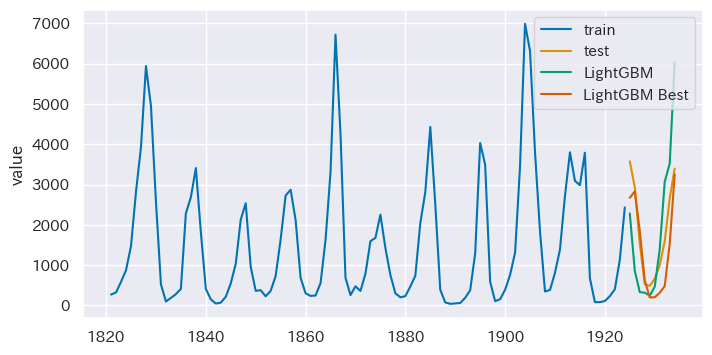

In [33]:
# 予測結果の可視化
fig, ax = plot_series(
    train_lynx,
    test_lynx,
    pred_lynx,
    best_gbm_pred_lynx,
    labels=["train", "test", "LightGBM", "LightGBM Best"],
    markers=np.tile("", 4),
)
fig.set_size_inches(8, 4)

In [34]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(start="1949-01", periods=len(air_passengers), freq="M")
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

In [35]:
# 訓練データとテストデータに分割する
train_air, test_air = temporal_train_test_split(air_passengers, test_size=36)

# 予測期間
fh_air = np.arange(1, len(test_air) + 1)

In [36]:
# LightGBMのハイパーパラメータを設定
params_3 = {
    "objective": "regression",  # 回帰を目的とする
    "seed": 1,  # 乱数の種
    "num_leaves": 60,  # 葉の数の最大値
    "learning_rate": 0.07,  # 学習率
    "n_estimators": 100,  # ブースティングの回数
    "min_data_in_leaf": 4,  # 1つの葉における最小データ数
    "verbose": -1,  # ワーニングなどの非表示
}

# モデル化
gbm_sk_air = lgb.LGBMRegressor(**params_3)

# 再帰的にLightGBMを実行
gbm_forecaster_air = make_reduction(
    gbm_sk_air, window_length=12, pooling="global", strategy="recursive"
)

# モデルの当てはめ
gbm_forecaster_air.fit(train_air)

RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(learning_rate=0.07, min_data_in_leaf=4, num_leaves=60,
              objective='regression', seed=1, verbose=-1),
                                     pooling='global', window_length=12)

In [37]:
# 予測の実施
gbm_pred_air = gbm_forecaster_air.predict(fh_air)

# 予測精度
mae = mean_absolute_error(test_air, gbm_pred_air)
mase = mean_absolute_scaled_error(test_air, gbm_pred_air, y_train=train_air)

print("MAE :", mae)
print("MASE:", mase)

MAE : 44.46762896753749
MASE: 2.188609153416059


In [38]:
# ===========================================
# トレンド除去（Detrender）の設定
# ===========================================

# ------------------------------------------------
# Detrender:
#   → 時系列データからトレンド成分（上昇や下降傾向）を除去する変換器。
#   → 内部的には、PolynomialTrendForecaster でトレンドを推定し、
#     それをデータから「引く（additive）」または「割る（multiplicative）」ことで補正する。
#
# PolynomialTrendForecaster:
#   → 多項式（線形・二次など）を用いてトレンドを近似するモデル。
#   → degree=1 なら線形（1次式）トレンド：
#        y_t ≈ β₀ + β₁·t
#
# model='multiplicative':
#   → 乗法型のトレンド除去を行う設定。
#     すなわち、データがトレンドと比例関係にあると仮定する。
#     （加法型: y_t = T_t + e_t に対して、
#       乗法型: y_t = T_t × e_t ）
# ------------------------------------------------

detrend = Detrender(
    forecaster=PolynomialTrendForecaster(degree=1),  # 線形トレンドを推定
    model="multiplicative",  # 乗法モデルとして除去
)

In [39]:
# ===========================================
# 前処理からモデル化までを1つのパイプラインにまとめる
# ===========================================

# ------------------------------------------------
# TransformedTargetForecaster:
#   → 時系列データの「変換（前処理）」と「予測モデル」を
#     一連の処理として結合するためのパイプライン。
#
#   この構造により、学習時（fit）・予測時（predict）ともに
#   同じ前処理手順を自動的に適用できる。
#
# 処理の流れ：
#   (1) Detrender でトレンド成分を除去
#   (2) LightGBM 回帰モデルを用いて残差系列を学習・予測
# ------------------------------------------------

pipe_gbm = TransformedTargetForecaster(
    steps=[
        detrend,  # (1) トレンド除去（先ほど定義した Detrender オブジェクト）
        # (2) LightGBM による時系列回帰
        (
            "forecast",
            make_reduction(
                gbm_sk_air,  # scikit-learn API 互換の LightGBM 回帰器
                window_length=12,  # 直近12時点を1系列として学習に使用（ラグ特徴量として扱う）
                pooling="global",  # 全系列を統合してモデル化（時系列が複数ある場合に有効）
                strategy="recursive",  # 予測結果を次時点の入力に再帰的に利用（多ステップ先予測）
            ),
        ),
    ]
)

# ------------------------------------------------
# 学習（モデル当てはめ）
# ------------------------------------------------
# train_air : 訓練用の時系列データ（例：月次航空旅客数など）
# パイプライン内で以下の処理が自動で実行される：
#   - トレンド除去
#   - ラグ特徴量の生成（過去12か月分）
#   - LightGBMによる回帰モデルの学習
pipe_gbm.fit(train_air)

TransformedTargetForecaster(steps=[Detrender(forecaster=PolynomialTrendForecaster(),
                                             model='multiplicative'),
                                   ('forecast',
                                    RecursiveTabularRegressionForecaster(estimator=LGBMRegressor(learning_rate=0.07, min_data_in_leaf=4, num_leaves=60,
              objective='regression', seed=1, verbose=-1),
                                                                         pooling='global',
                                                                         window_length=12))])

In [40]:
# 予測の実施
pipe_gbm_pred = pipe_gbm.predict(fh_air)

# 予測精度
mae = mean_absolute_error(test_air, pipe_gbm_pred)
mase = mean_absolute_scaled_error(test_air, pipe_gbm_pred, y_train=train_air)

print("MAE :", mae)
print("MASE:", mase)

MAE : 18.329759413136905
MASE: 0.9021546721277134
